# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

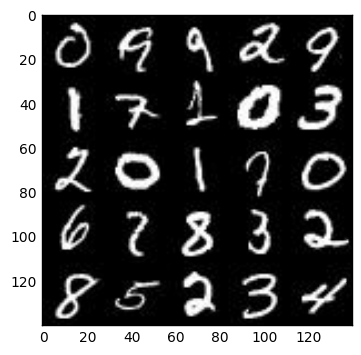

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

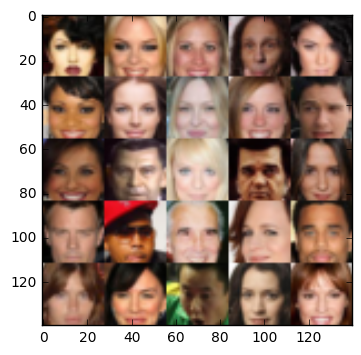

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


In [6]:
ALPHA = 0.2

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        conv_1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        conv_1 = tf.maximum(ALPHA * conv_1, conv_1)
        
        conv_2 = tf.layers.conv2d(conv_1, filters=128, kernel_size=5, strides=2, padding='same')
        conv_2 = tf.layers.batch_normalization(conv_2, training=True)
        conv_2 = tf.maximum(conv_2 * ALPHA, conv_2)

        conv_3 = tf.layers.conv2d(conv_2, filters=256, kernel_size=5, strides=2, padding='same')
        conv_3 = tf.layers.batch_normalization(conv_3, training=True)
        conv_3 = tf.maximum(conv_3 * ALPHA, conv_3)
        
        flattened = tf.reshape(conv_3, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)
        
        return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        layer = tf.layers.dense(z, 4 * 4 * 512)
        layer = tf.reshape(layer, (-1, 4, 4, 512))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(ALPHA * layer, layer)

        conv1 = tf.layers.conv2d_transpose(layer, 256, 4, 1, padding='valid')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(ALPHA * conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 4, 1, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(ALPHA * conv2, conv2)
        
        conv3 = tf.layers.conv2d_transpose(conv2, 64, 5, 2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(ALPHA * conv3, conv3)
        
        conv4 = tf.layers.conv2d_transpose(conv3, 32, 5, 2, padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=is_train)
        conv4 = tf.maximum(ALPHA * conv4, conv4)
        
        logits = tf.layers.conv2d_transpose(conv4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        d_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_ops, g_train_ops

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    random_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(generator(input_z, out_channel_dim, False), feed_dict={input_z: random_z})

    img_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(img_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    _iters = 0
    _show = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                _iters += 1     
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate})
                _ = sess.run(gen_ops, feed_dict={input_z: batch_z, in_learning_rate: learning_rate })
                
                dis_loss_train = dis_loss.eval({input_z: batch_z, input_real: batch_images})
                gen_loss_train = gen_loss.eval({input_z: batch_z})

                print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                     "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                     "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if _iters % _show == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/3... Discriminator Loss: 14.3738... Generator Loss: 0.0000
Epoch 1/3... Discriminator Loss: 7.2188... Generator Loss: 0.0015
Epoch 1/3... Discriminator Loss: 5.9119... Generator Loss: 1.0950
Epoch 1/3... Discriminator Loss: 6.7873... Generator Loss: 0.0037
Epoch 1/3... Discriminator Loss: 0.6139... Generator Loss: 4.3721
Epoch 1/3... Discriminator Loss: 8.6224... Generator Loss: 0.0003
Epoch 1/3... Discriminator Loss: 2.7169... Generator Loss: 6.3961
Epoch 1/3... Discriminator Loss: 4.9433... Generator Loss: 0.0115
Epoch 1/3... Discriminator Loss: 1.7861... Generator Loss: 8.8800
Epoch 1/3... Discriminator Loss: 7.2891... Generator Loss: 0.0011
Epoch 1/3... Discriminator Loss: 2.3604... Generator Loss: 7.1766
Epoch 1/3... Discriminator Loss: 1.9138... Generator Loss: 0.2865
Epoch 1/3... Discriminator Loss: 1.2973... Generator Loss: 3.7803
Epoch 1/3... Discriminator Loss: 3.3351... Generator Loss: 0.0565
Epoch 1/3... Discriminator Loss: 2.0397... Generator Loss: 9.6262
Epoch 1/3

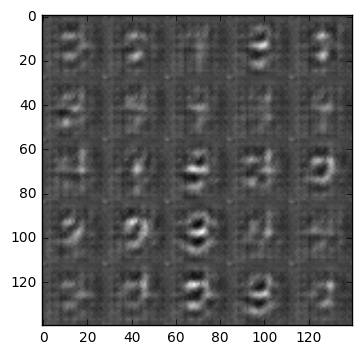

Epoch 1/3... Discriminator Loss: 0.9535... Generator Loss: 1.1868
Epoch 1/3... Discriminator Loss: 0.9884... Generator Loss: 1.2099
Epoch 1/3... Discriminator Loss: 0.9974... Generator Loss: 1.1589
Epoch 1/3... Discriminator Loss: 0.9047... Generator Loss: 1.3317
Epoch 1/3... Discriminator Loss: 1.0241... Generator Loss: 1.1075
Epoch 1/3... Discriminator Loss: 1.0891... Generator Loss: 1.1472
Epoch 1/3... Discriminator Loss: 1.1154... Generator Loss: 1.0943
Epoch 1/3... Discriminator Loss: 1.2463... Generator Loss: 0.9423
Epoch 1/3... Discriminator Loss: 1.1761... Generator Loss: 1.1212
Epoch 1/3... Discriminator Loss: 1.2495... Generator Loss: 0.7236
Epoch 1/3... Discriminator Loss: 1.2474... Generator Loss: 1.6911
Epoch 1/3... Discriminator Loss: 1.6906... Generator Loss: 0.3750
Epoch 1/3... Discriminator Loss: 2.0213... Generator Loss: 3.4009
Epoch 1/3... Discriminator Loss: 2.0970... Generator Loss: 0.2449
Epoch 1/3... Discriminator Loss: 1.5657... Generator Loss: 2.4549
Epoch 1/3.

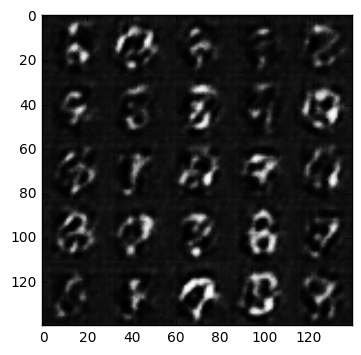

Epoch 1/3... Discriminator Loss: 1.2143... Generator Loss: 1.8324
Epoch 1/3... Discriminator Loss: 1.2374... Generator Loss: 0.6185
Epoch 1/3... Discriminator Loss: 1.2043... Generator Loss: 1.4288
Epoch 1/3... Discriminator Loss: 1.2607... Generator Loss: 0.6382
Epoch 1/3... Discriminator Loss: 1.1856... Generator Loss: 1.7285
Epoch 1/3... Discriminator Loss: 1.4199... Generator Loss: 0.4583
Epoch 1/3... Discriminator Loss: 1.3949... Generator Loss: 2.1908
Epoch 1/3... Discriminator Loss: 1.4401... Generator Loss: 0.4532
Epoch 1/3... Discriminator Loss: 1.1876... Generator Loss: 1.9311
Epoch 1/3... Discriminator Loss: 1.2305... Generator Loss: 0.6223
Epoch 1/3... Discriminator Loss: 1.0888... Generator Loss: 1.4189
Epoch 1/3... Discriminator Loss: 1.0863... Generator Loss: 0.8349
Epoch 1/3... Discriminator Loss: 1.0616... Generator Loss: 1.2073
Epoch 1/3... Discriminator Loss: 1.1333... Generator Loss: 0.7750
Epoch 1/3... Discriminator Loss: 1.1199... Generator Loss: 1.6724
Epoch 1/3.

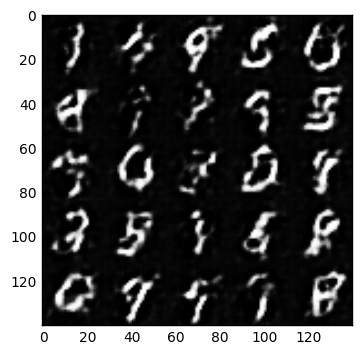

Epoch 1/3... Discriminator Loss: 1.1109... Generator Loss: 1.0769
Epoch 1/3... Discriminator Loss: 1.1228... Generator Loss: 0.8401
Epoch 1/3... Discriminator Loss: 1.1391... Generator Loss: 1.0582
Epoch 1/3... Discriminator Loss: 1.1414... Generator Loss: 0.7922
Epoch 1/3... Discriminator Loss: 1.1166... Generator Loss: 1.1281
Epoch 1/3... Discriminator Loss: 1.1601... Generator Loss: 0.7199
Epoch 1/3... Discriminator Loss: 1.1227... Generator Loss: 1.4720
Epoch 1/3... Discriminator Loss: 1.5469... Generator Loss: 0.3826
Epoch 1/3... Discriminator Loss: 1.9328... Generator Loss: 2.5268
Epoch 1/3... Discriminator Loss: 1.7832... Generator Loss: 0.2962
Epoch 1/3... Discriminator Loss: 2.9997... Generator Loss: 3.4614
Epoch 1/3... Discriminator Loss: 2.2104... Generator Loss: 0.1906
Epoch 1/3... Discriminator Loss: 1.4530... Generator Loss: 1.7228
Epoch 1/3... Discriminator Loss: 1.2936... Generator Loss: 0.7078
Epoch 1/3... Discriminator Loss: 1.2876... Generator Loss: 0.7464
Epoch 1/3.

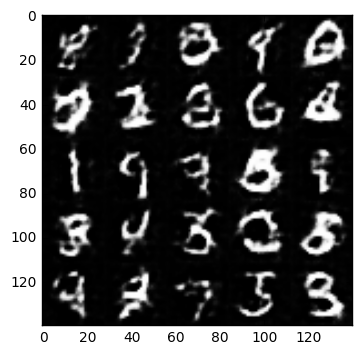

Epoch 1/3... Discriminator Loss: 1.2855... Generator Loss: 0.6164
Epoch 1/3... Discriminator Loss: 1.2558... Generator Loss: 1.0728
Epoch 1/3... Discriminator Loss: 1.1945... Generator Loss: 0.7220
Epoch 1/3... Discriminator Loss: 1.2001... Generator Loss: 1.3354
Epoch 1/3... Discriminator Loss: 1.4680... Generator Loss: 0.4416
Epoch 1/3... Discriminator Loss: 1.4437... Generator Loss: 1.5894
Epoch 1/3... Discriminator Loss: 1.2791... Generator Loss: 0.5811
Epoch 1/3... Discriminator Loss: 1.2373... Generator Loss: 1.3429
Epoch 1/3... Discriminator Loss: 1.5013... Generator Loss: 0.4256
Epoch 1/3... Discriminator Loss: 1.3556... Generator Loss: 1.5709
Epoch 1/3... Discriminator Loss: 1.3776... Generator Loss: 0.5165
Epoch 1/3... Discriminator Loss: 1.2704... Generator Loss: 1.3343
Epoch 1/3... Discriminator Loss: 1.3437... Generator Loss: 0.5811
Epoch 1/3... Discriminator Loss: 1.2281... Generator Loss: 1.2320
Epoch 1/3... Discriminator Loss: 1.2369... Generator Loss: 0.6611
Epoch 1/3.

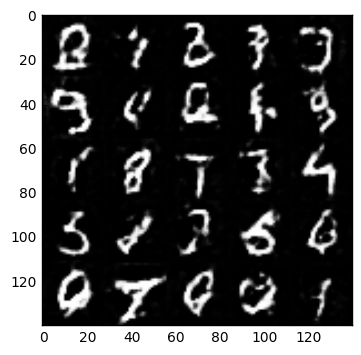

Epoch 2/3... Discriminator Loss: 1.2027... Generator Loss: 0.7707
Epoch 2/3... Discriminator Loss: 1.1598... Generator Loss: 1.0007
Epoch 2/3... Discriminator Loss: 1.2479... Generator Loss: 0.7228
Epoch 2/3... Discriminator Loss: 1.1559... Generator Loss: 1.0617
Epoch 2/3... Discriminator Loss: 1.1824... Generator Loss: 0.7582
Epoch 2/3... Discriminator Loss: 1.1758... Generator Loss: 1.0033
Epoch 2/3... Discriminator Loss: 1.1959... Generator Loss: 0.7708
Epoch 2/3... Discriminator Loss: 1.1837... Generator Loss: 1.0049
Epoch 2/3... Discriminator Loss: 1.2299... Generator Loss: 0.6586
Epoch 2/3... Discriminator Loss: 1.1391... Generator Loss: 1.2751
Epoch 2/3... Discriminator Loss: 1.3058... Generator Loss: 0.5729
Epoch 2/3... Discriminator Loss: 1.4106... Generator Loss: 1.6153
Epoch 2/3... Discriminator Loss: 1.6671... Generator Loss: 0.3552
Epoch 2/3... Discriminator Loss: 2.5778... Generator Loss: 2.2704
Epoch 2/3... Discriminator Loss: 1.7346... Generator Loss: 0.3134
Epoch 2/3.

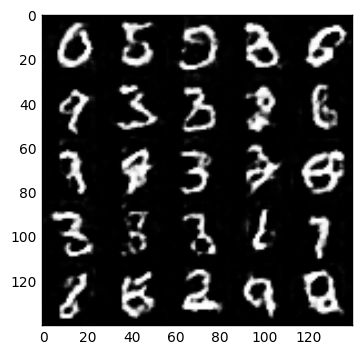

Epoch 2/3... Discriminator Loss: 1.2453... Generator Loss: 0.6734
Epoch 2/3... Discriminator Loss: 1.1451... Generator Loss: 1.2136
Epoch 2/3... Discriminator Loss: 1.2933... Generator Loss: 0.6140
Epoch 2/3... Discriminator Loss: 1.0974... Generator Loss: 1.1430
Epoch 2/3... Discriminator Loss: 1.2748... Generator Loss: 0.6399
Epoch 2/3... Discriminator Loss: 1.2148... Generator Loss: 1.1885
Epoch 2/3... Discriminator Loss: 1.3344... Generator Loss: 0.5504
Epoch 2/3... Discriminator Loss: 1.2800... Generator Loss: 1.3944
Epoch 2/3... Discriminator Loss: 1.2942... Generator Loss: 0.6493
Epoch 2/3... Discriminator Loss: 1.2598... Generator Loss: 1.3654
Epoch 2/3... Discriminator Loss: 1.7735... Generator Loss: 0.3021
Epoch 2/3... Discriminator Loss: 1.7628... Generator Loss: 2.0749
Epoch 2/3... Discriminator Loss: 1.5055... Generator Loss: 0.4370
Epoch 2/3... Discriminator Loss: 1.7347... Generator Loss: 1.4010
Epoch 2/3... Discriminator Loss: 1.5327... Generator Loss: 0.4064
Epoch 2/3.

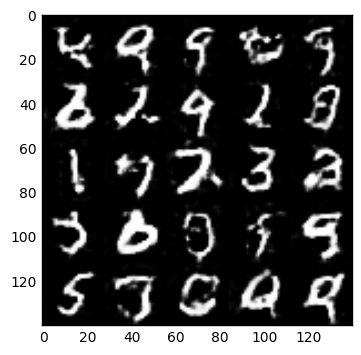

Epoch 2/3... Discriminator Loss: 1.4307... Generator Loss: 1.4755
Epoch 2/3... Discriminator Loss: 1.1173... Generator Loss: 0.8753
Epoch 2/3... Discriminator Loss: 1.2098... Generator Loss: 0.7797
Epoch 2/3... Discriminator Loss: 1.1487... Generator Loss: 1.1447
Epoch 2/3... Discriminator Loss: 1.5072... Generator Loss: 0.4243
Epoch 2/3... Discriminator Loss: 1.8910... Generator Loss: 1.9707
Epoch 2/3... Discriminator Loss: 1.9399... Generator Loss: 0.2419
Epoch 2/3... Discriminator Loss: 2.2348... Generator Loss: 2.1246
Epoch 2/3... Discriminator Loss: 1.3981... Generator Loss: 0.5422
Epoch 2/3... Discriminator Loss: 1.2607... Generator Loss: 1.3080
Epoch 2/3... Discriminator Loss: 1.3567... Generator Loss: 0.5535
Epoch 2/3... Discriminator Loss: 1.3061... Generator Loss: 1.4016
Epoch 2/3... Discriminator Loss: 1.4923... Generator Loss: 0.4411
Epoch 2/3... Discriminator Loss: 1.4224... Generator Loss: 1.5629
Epoch 2/3... Discriminator Loss: 1.4712... Generator Loss: 0.4528
Epoch 2/3.

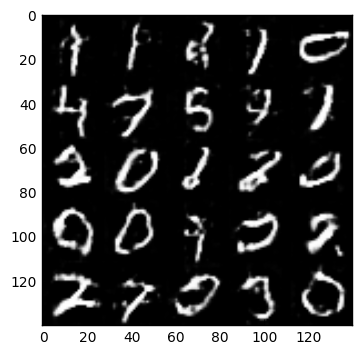

Epoch 2/3... Discriminator Loss: 1.1560... Generator Loss: 1.2968
Epoch 2/3... Discriminator Loss: 1.2817... Generator Loss: 0.6238
Epoch 2/3... Discriminator Loss: 1.1878... Generator Loss: 1.1796
Epoch 2/3... Discriminator Loss: 1.3477... Generator Loss: 0.5592
Epoch 2/3... Discriminator Loss: 1.2315... Generator Loss: 1.1943
Epoch 2/3... Discriminator Loss: 1.1642... Generator Loss: 0.8075
Epoch 2/3... Discriminator Loss: 1.2143... Generator Loss: 0.8408
Epoch 2/3... Discriminator Loss: 1.1680... Generator Loss: 0.7557
Epoch 2/3... Discriminator Loss: 1.1532... Generator Loss: 1.2021
Epoch 2/3... Discriminator Loss: 1.2221... Generator Loss: 0.6665
Epoch 2/3... Discriminator Loss: 1.2358... Generator Loss: 1.3075
Epoch 2/3... Discriminator Loss: 1.4745... Generator Loss: 0.4443
Epoch 2/3... Discriminator Loss: 1.5801... Generator Loss: 1.6254
Epoch 2/3... Discriminator Loss: 1.2180... Generator Loss: 0.7475
Epoch 2/3... Discriminator Loss: 1.2134... Generator Loss: 0.9769
Epoch 2/3.

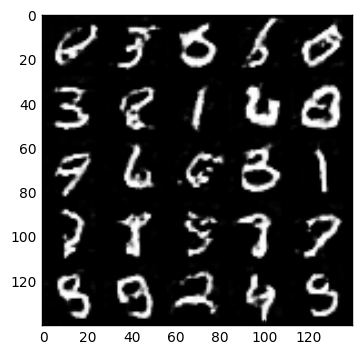

Epoch 2/3... Discriminator Loss: 1.1534... Generator Loss: 1.1410
Epoch 2/3... Discriminator Loss: 1.3549... Generator Loss: 0.5291
Epoch 2/3... Discriminator Loss: 1.2403... Generator Loss: 1.4677
Epoch 2/3... Discriminator Loss: 1.2932... Generator Loss: 0.5960
Epoch 2/3... Discriminator Loss: 1.4445... Generator Loss: 1.3531
Epoch 2/3... Discriminator Loss: 1.9397... Generator Loss: 0.2536
Epoch 2/3... Discriminator Loss: 2.2157... Generator Loss: 2.5223
Epoch 2/3... Discriminator Loss: 1.3093... Generator Loss: 0.5907
Epoch 2/3... Discriminator Loss: 1.3641... Generator Loss: 1.5906
Epoch 2/3... Discriminator Loss: 1.5229... Generator Loss: 0.4292
Epoch 2/3... Discriminator Loss: 1.3417... Generator Loss: 1.5157
Epoch 2/3... Discriminator Loss: 1.3247... Generator Loss: 0.5746
Epoch 2/3... Discriminator Loss: 1.2540... Generator Loss: 1.1538
Epoch 2/3... Discriminator Loss: 1.3013... Generator Loss: 0.6368
Epoch 2/3... Discriminator Loss: 1.2344... Generator Loss: 1.0268
Epoch 2/3.

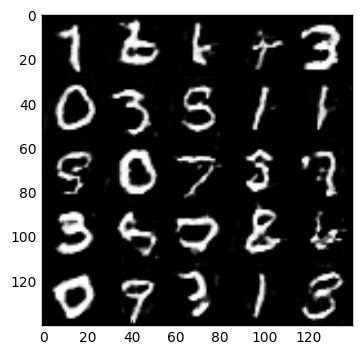

Epoch 3/3... Discriminator Loss: 1.1415... Generator Loss: 0.9433
Epoch 3/3... Discriminator Loss: 1.0977... Generator Loss: 0.9213
Epoch 3/3... Discriminator Loss: 1.1417... Generator Loss: 0.8687
Epoch 3/3... Discriminator Loss: 1.2062... Generator Loss: 0.8282
Epoch 3/3... Discriminator Loss: 1.1306... Generator Loss: 0.8598
Epoch 3/3... Discriminator Loss: 1.1528... Generator Loss: 0.9556
Epoch 3/3... Discriminator Loss: 1.1537... Generator Loss: 0.8479
Epoch 3/3... Discriminator Loss: 1.1290... Generator Loss: 0.9813
Epoch 3/3... Discriminator Loss: 1.1970... Generator Loss: 0.7573
Epoch 3/3... Discriminator Loss: 1.1563... Generator Loss: 0.9597
Epoch 3/3... Discriminator Loss: 1.0324... Generator Loss: 1.0204
Epoch 3/3... Discriminator Loss: 1.3178... Generator Loss: 0.5866
Epoch 3/3... Discriminator Loss: 1.2376... Generator Loss: 1.4103
Epoch 3/3... Discriminator Loss: 1.3869... Generator Loss: 0.4929
Epoch 3/3... Discriminator Loss: 1.6154... Generator Loss: 1.9569
Epoch 3/3.

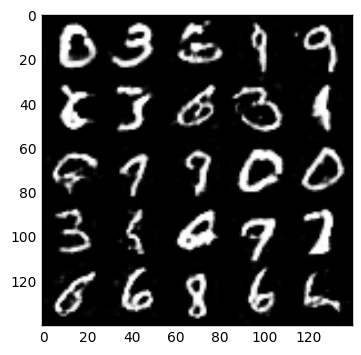

Epoch 3/3... Discriminator Loss: 1.1779... Generator Loss: 0.7893
Epoch 3/3... Discriminator Loss: 1.1873... Generator Loss: 1.1109
Epoch 3/3... Discriminator Loss: 1.4343... Generator Loss: 0.5016
Epoch 3/3... Discriminator Loss: 1.4185... Generator Loss: 1.3612
Epoch 3/3... Discriminator Loss: 1.1508... Generator Loss: 0.6987
Epoch 3/3... Discriminator Loss: 1.2554... Generator Loss: 1.6819
Epoch 3/3... Discriminator Loss: 1.6820... Generator Loss: 0.3346
Epoch 3/3... Discriminator Loss: 1.7478... Generator Loss: 2.2519
Epoch 3/3... Discriminator Loss: 1.5001... Generator Loss: 0.4627
Epoch 3/3... Discriminator Loss: 1.2004... Generator Loss: 1.4087
Epoch 3/3... Discriminator Loss: 1.1941... Generator Loss: 0.7897
Epoch 3/3... Discriminator Loss: 1.2313... Generator Loss: 0.8171
Epoch 3/3... Discriminator Loss: 1.1623... Generator Loss: 1.0048
Epoch 3/3... Discriminator Loss: 1.2338... Generator Loss: 0.6753
Epoch 3/3... Discriminator Loss: 1.2057... Generator Loss: 1.1963
Epoch 3/3.

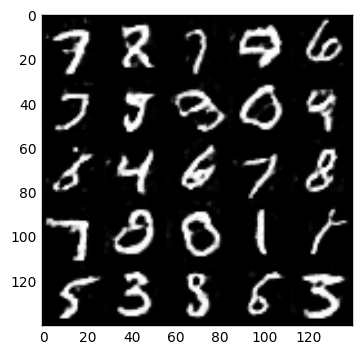

Epoch 3/3... Discriminator Loss: 1.1803... Generator Loss: 0.9917
Epoch 3/3... Discriminator Loss: 1.1795... Generator Loss: 0.7244
Epoch 3/3... Discriminator Loss: 1.1378... Generator Loss: 1.1324
Epoch 3/3... Discriminator Loss: 1.1183... Generator Loss: 0.8949
Epoch 3/3... Discriminator Loss: 1.1080... Generator Loss: 0.8160
Epoch 3/3... Discriminator Loss: 1.1926... Generator Loss: 1.2841
Epoch 3/3... Discriminator Loss: 1.5701... Generator Loss: 0.3861
Epoch 3/3... Discriminator Loss: 2.1849... Generator Loss: 2.3778
Epoch 3/3... Discriminator Loss: 1.2377... Generator Loss: 0.7138
Epoch 3/3... Discriminator Loss: 1.2018... Generator Loss: 0.9864
Epoch 3/3... Discriminator Loss: 1.2031... Generator Loss: 0.8995
Epoch 3/3... Discriminator Loss: 1.1890... Generator Loss: 0.8942
Epoch 3/3... Discriminator Loss: 1.2270... Generator Loss: 0.8108
Epoch 3/3... Discriminator Loss: 1.3095... Generator Loss: 0.7869
Epoch 3/3... Discriminator Loss: 1.3011... Generator Loss: 0.8370
Epoch 3/3.

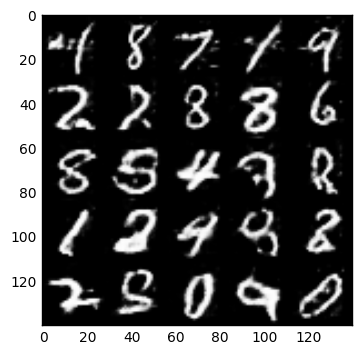

Epoch 3/3... Discriminator Loss: 1.2462... Generator Loss: 1.0189
Epoch 3/3... Discriminator Loss: 1.3014... Generator Loss: 0.7181
Epoch 3/3... Discriminator Loss: 1.2036... Generator Loss: 0.8853
Epoch 3/3... Discriminator Loss: 1.2201... Generator Loss: 0.8451
Epoch 3/3... Discriminator Loss: 1.1875... Generator Loss: 0.9027
Epoch 3/3... Discriminator Loss: 1.2246... Generator Loss: 0.7629
Epoch 3/3... Discriminator Loss: 1.1491... Generator Loss: 1.0016
Epoch 3/3... Discriminator Loss: 1.2252... Generator Loss: 0.8031
Epoch 3/3... Discriminator Loss: 1.1935... Generator Loss: 0.8143
Epoch 3/3... Discriminator Loss: 1.1435... Generator Loss: 1.0046
Epoch 3/3... Discriminator Loss: 1.2948... Generator Loss: 0.6555
Epoch 3/3... Discriminator Loss: 1.0961... Generator Loss: 1.1415
Epoch 3/3... Discriminator Loss: 1.3868... Generator Loss: 0.5668
Epoch 3/3... Discriminator Loss: 1.1864... Generator Loss: 1.1586
Epoch 3/3... Discriminator Loss: 1.2268... Generator Loss: 0.6825
Epoch 3/3.

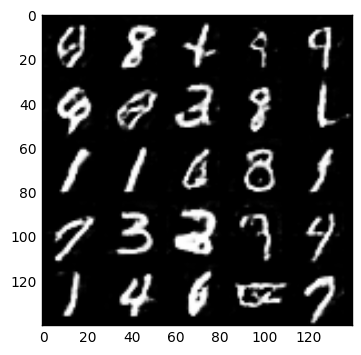

Epoch 3/3... Discriminator Loss: 1.1437... Generator Loss: 1.1554
Epoch 3/3... Discriminator Loss: 1.2981... Generator Loss: 0.6091
Epoch 3/3... Discriminator Loss: 1.1487... Generator Loss: 1.3148
Epoch 3/3... Discriminator Loss: 1.2454... Generator Loss: 0.6260


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.0811... Generator Loss: 0.0341
Epoch 1/1... Discriminator Loss: 2.0843... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 4.4488... Generator Loss: 0.0275
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 3.6039
Epoch 1/1... Discriminator Loss: 5.6290... Generator Loss: 0.0090
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 6.2345
Epoch 1/1... Discriminator Loss: 3.4630... Generator Loss: 0.0664
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 7.8495
Epoch 1/1... Discriminator Loss: 2.9484... Generator Loss: 0.1449
Epoch 1/1... Discriminator Loss: 1.6947... Generator Loss: 9.3868
Epoch 1/1... Discriminator Loss: 4.8021... Generator Loss: 0.0185
Epoch 1/1... Discriminator Loss: 2.0463... Generator Loss: 10.2539
Epoch 1/1... Discriminator Loss: 1.7386... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 2.9797
Epoch 1/1... Discriminator Loss: 6.2323... Generator Loss: 0.0043
Epoch 1/1

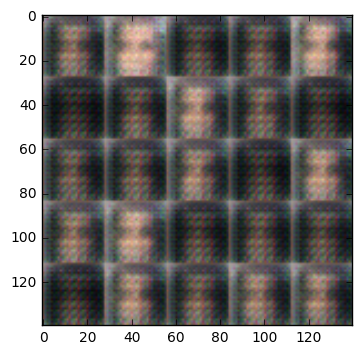

Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 1.8170
Epoch 1/1... Discriminator Loss: 1.6205... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 2.1393
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 2.7675
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 2.2116
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 2.0930
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 2.2620
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.8008
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.9223
Epoch 1/1.

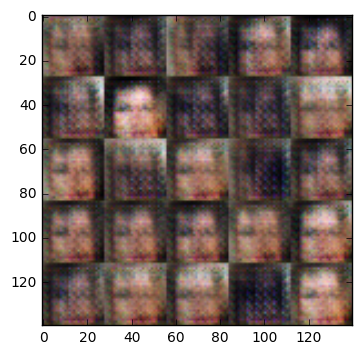

Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 2.1465
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 1.1011
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 1.2504
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 1.8011
Epoch 1/1.

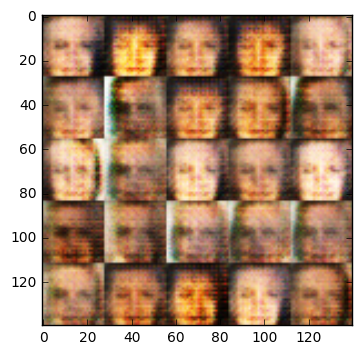

Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 1.6176
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 1.2895
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 1.0033
Epoch 1/1.

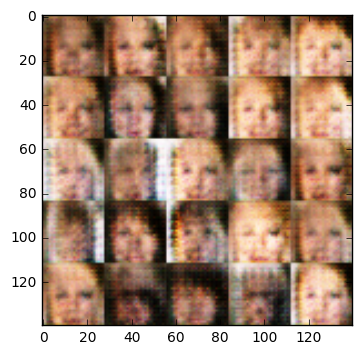

Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 1.2591
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 1.6225... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8814
Epoch 1/1.

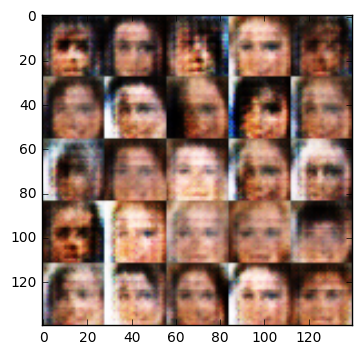

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 1.0496
Epoch 1/1.

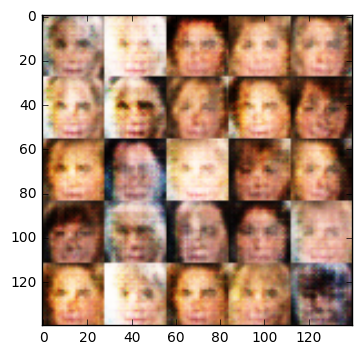

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.8645
Epoch 1/1.

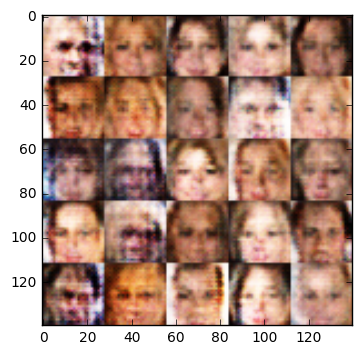

Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 1.1678
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6966
Epoch 1/1.

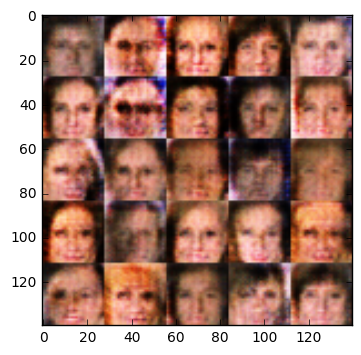

Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 1.5235
Epoch 1/1... Discriminator Loss: 1.6527... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.6110
Epoch 1/1.

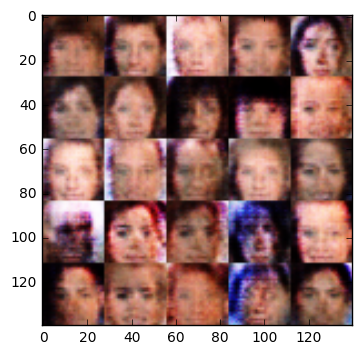

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.9470
Epoch 1/1.

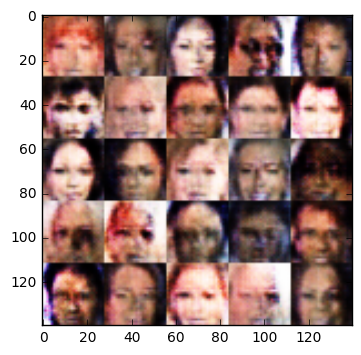

Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.4863
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 1.4127
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.6905
Epoch 1/1.

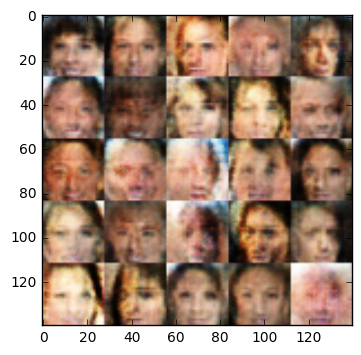

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.8570
Epoch 1/1.

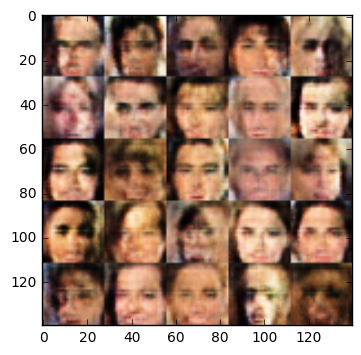

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7708
Epoch 1/1.

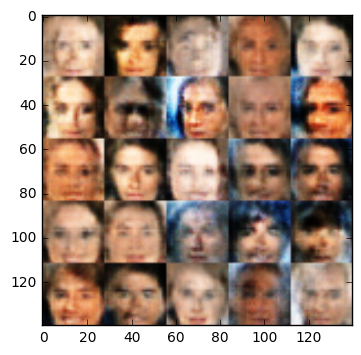

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 1.1567
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7041
Epoch 1/1.

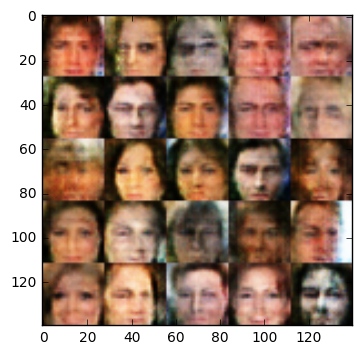

Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.0393
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 1.1296
Epoch 1/1.

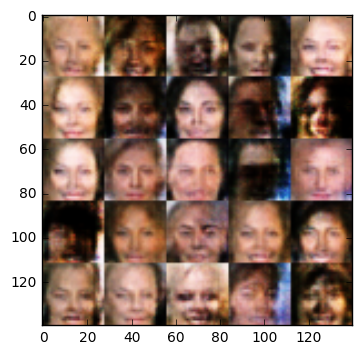

Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.7473
Epoch 1/1.

In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.